# **Assignment 3 - RNN - Weather Time Series Forcasting**

# **Name: Siva Sai Madhumitha Kotala**


**An example of temperature forecasting: Data uploaded from keras to Amazon Web Services (AWS)**

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-04 21:09:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.125.240, 52.217.18.78, 52.217.171.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.125.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.7MB/s    in 0.3s    

2024-04-04 21:09:59 (43.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Examining the 420451 rows and 15 features of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Data parsing involves transforming the comma-separated values into floating-point numbers and saving particular values in the raw_data and temperature arrays for later processing or analysis.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**The temperature time series is plotted.**

Text(0, 0.5, 'Temperature')

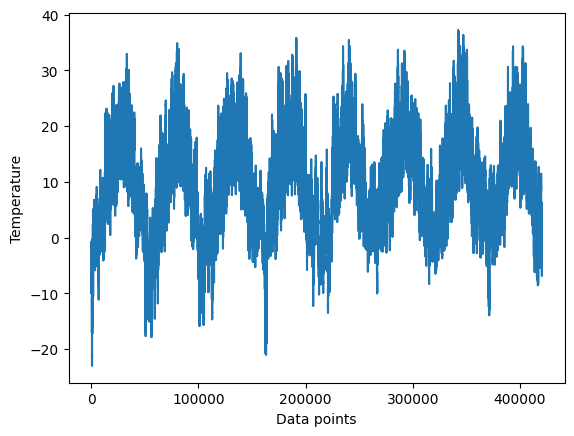

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first ten days of the temperature time series yields 1440 data points because one day's worth of data contains 144 data points.**

Text(0, 0.5, 'Temperature')

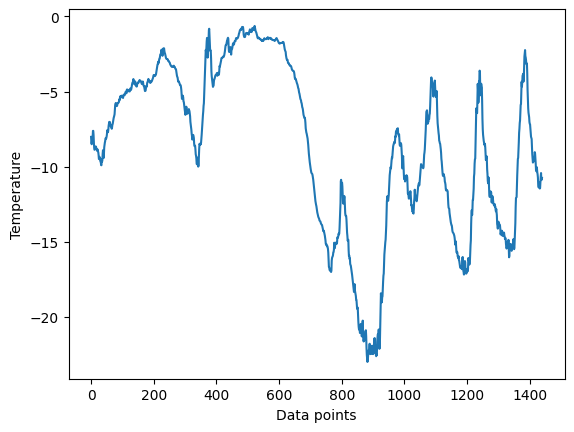

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating how many samples each data split will require: 50% for train, 25% for validation**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Data normalization: No vectorization is required because the data is already in a numerical representation. But it's best to standardize all the variables because the data scales vary from variable to variable—for example, the temperature can range from -20 to +30 and the pressure takes millibars.**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating datasets for testing, validation, and training is necessary because the dataset's samples are largely duplicated. Thus, explicitly allocating memory for every sample would be inefficient. Rather, we shall produce the samples in real time.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Examining the results of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Calculating the common-sense baseline MAE - The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a straightforward forecasting technique that uses the final value in the input sequence to predict the value that will come after it.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


It is reasonable to assume that the temperature will remain unchanged for the next twenty-four hours. Using the simple baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, whereas the test MAE is 2.62 degrees Celsius. Put otherwise, an average divergence of almost 2.5 degrees would arise from presuming that the future temperature stays constant with the current one.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.Flatten()(inputs)
mad = layers.Dense(16, activation="relu")(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 14.2294 - mae: 2.9156 - val_loss: 13.7721 - val_mae: 2.9562
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.8076 - mae: 2.4618 - val_loss: 10.5067 - val_mae: 2.5606
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.9386 - mae: 2.3566 - val_loss: 12.8615 - val_mae: 2.8485
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 8.3861 - mae: 2.2875 - val_loss: 12.8096 - val_mae: 2.8488
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.9966 - mae: 2.2335 - val_loss: 13.2583 - val_mae: 2.8892
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.6665 - mae: 2.1889 - val_loss: 10.9030 - val_mae: 2.6138
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.4485 - mae: 2.1574 - val_loss: 11.4275 - val_mae: 2.6865
Epoch 8/10
819/819 [==============================] - 8s 10ms

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 7ms/step - loss: 11.3070 - mae: 2.6472
Test MAE: 2.65


**Plotting results**

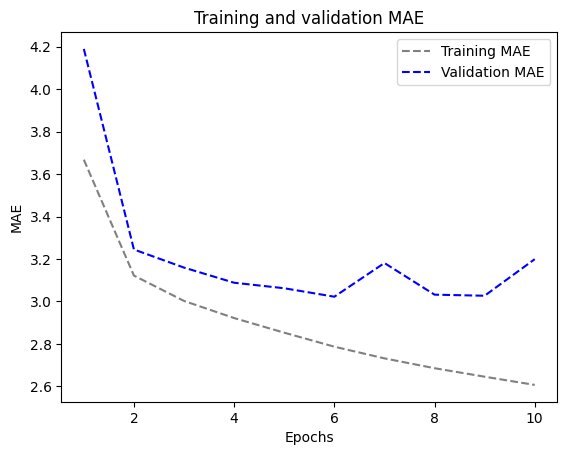

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.Conv1D(8, 24, activation="relu")(inputs)
mad = layers.MaxPooling1D(2)(mad)
mad = layers.Conv1D(8, 12, activation="relu")(mad)
mad = layers.MaxPooling1D(2)(mad)
mad = layers.Conv1D(8, 6, activation="relu")(mad)
mad = layers.GlobalAveragePooling1D()(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 21.7498 - mae: 3.6676 - val_loss: 27.2698 - val_mae: 4.1889
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 15.4673 - mae: 3.1220 - val_loss: 17.0066 - val_mae: 3.2448
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.3189 - mae: 3.0026 - val_loss: 15.8611 - val_mae: 3.1596
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 13.5663 - mae: 2.9221 - val_loss: 15.3396 - val_mae: 3.0884
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 12.9442 - mae: 2.8532 - val_loss: 15.2801 - val_mae: 3.0624
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 12.3651 - mae: 2.7873 - val_loss: 14.8799 - val_mae: 3.0225
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 11.8927 - mae: 2.7323 - val_loss: 16.2829 - val_mae: 3.1812
Epoch 8/10
819/819 [============================

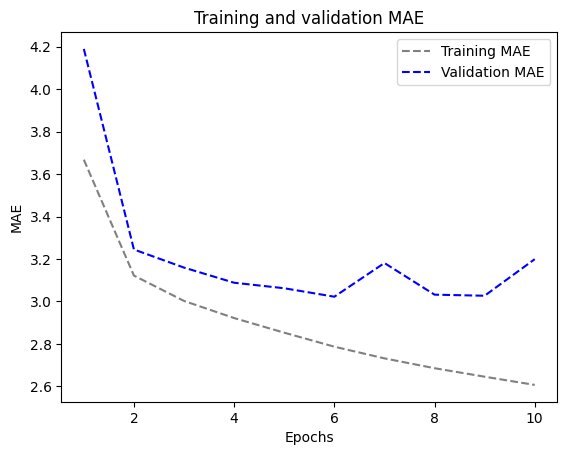

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*Compared to a dense model or common sense, it appears that the convolutional data did poorly. This might be the case because*.

*- The meteorological data does not conform well to the translation invariance assumption.*


*- It is important to note the data's order. Compared to data collected several days ago, recent historical data is noticeably more relevant for forecasting the temperature of the upcoming day. Unfortunately, this important temporal order cannot be captured well by a 1D convolutional neural network.*







## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 23ms/step - loss: 138.6955 - mae: 9.6990 - val_loss: 144.1742 - val_mae: 9.9190
Epoch 2/10
819/819 [==============================] - 19s 23ms/step - loss: 136.4930 - mae: 9.5719 - val_loss: 143.7614 - val_mae: 9.8785
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 136.3231 - mae: 9.5552 - val_loss: 143.6823 - val_mae: 9.8692
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 136.2639 - mae: 9.5489 - val_loss: 143.7443 - val_mae: 9.8743
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 136.2581 - mae: 9.5453 - val_loss: 143.5548 - val_mae: 9.8511
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1943 - mae: 9.5392 - val_loss: 143.5562 - val_mae: 9.8489
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1649 - mae: 9.5369 - val_loss: 143.5439 - val_mae: 9.8489
Epoch 8/10
819/819 [==============

### **2.Simple RNN - Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
mad = layers.SimpleRNN(16, return_sequences=True)(inputs)
mad = layers.SimpleRNN(16, return_sequences=True)(mad)
outputs = layers.SimpleRNN(16)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 58s 68ms/step - loss: 136.7196 - mae: 9.5639 - val_loss: 143.4545 - val_mae: 9.8406
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 136.0166 - mae: 9.5200 - val_loss: 143.4130 - val_mae: 9.8340
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 135.9792 - mae: 9.5162 - val_loss: 143.3987 - val_mae: 9.8315
Epoch 4/10
819/819 [==============================] - 55s 68ms/step - loss: 135.9436 - mae: 9.5120 - val_loss: 143.4259 - val_mae: 9.8383
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 135.9187 - mae: 9.5089 - val_loss: 143.4163 - val_mae: 9.8369
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8894 - mae: 9.5040 - val_loss: 143.4066 - val_mae: 9.8345
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 135.8661 - mae: 9.5010 - val_loss: 143.4762 - val_mae: 9.8499
Epoch 8/10
819/819 [==============

## **A Simple GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 44.6751 - mae: 4.8576 - val_loss: 13.8026 - val_mae: 2.7771
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 11.0090 - mae: 2.5778 - val_loss: 9.7877 - val_mae: 2.4168
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.9424 - mae: 2.4673 - val_loss: 9.9559 - val_mae: 2.4294
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.6113 - mae: 2.4246 - val_loss: 9.8293 - val_mae: 2.4075
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 9.3287 - mae: 2.3883 - val_loss: 10.0286 - val_mae: 2.4175
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 9.0758 - mae: 2.3569 - val_loss: 9.8548 - val_mae: 2.3963
Epoch 7/10
819/819 [==============================] - 45s 54ms/step - loss: 8.9018 - mae: 2.3338 - val_loss: 9.9249 - val_mae: 2.4012
Epoch 8/10
819/819 [==============================] - 43s 

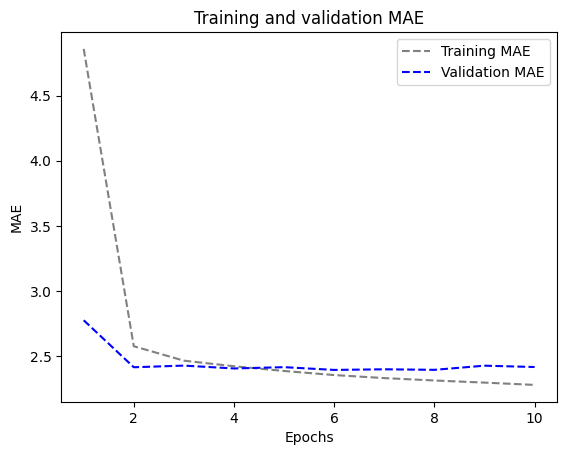

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 58ms/step - loss: 41.2737 - mae: 4.6759 - val_loss: 12.2779 - val_mae: 2.6657
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 11.0269 - mae: 2.5702 - val_loss: 9.5501 - val_mae: 2.4082
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 9.7975 - mae: 2.4306 - val_loss: 9.3324 - val_mae: 2.3711
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 9.2726 - mae: 2.3664 - val_loss: 9.7160 - val_mae: 2.4210
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 8.8660 - mae: 2.3168 - val_loss: 9.9185 - val_mae: 2.4293
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.5913 - mae: 2.2818 - val_loss: 9.6415 - val_mae: 2.3979
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.3129 - mae: 2.2449 - val_loss: 9.9163 - val_mae: 2.4311
Epoch 8/10
819/819 [==============================] - 46s 5

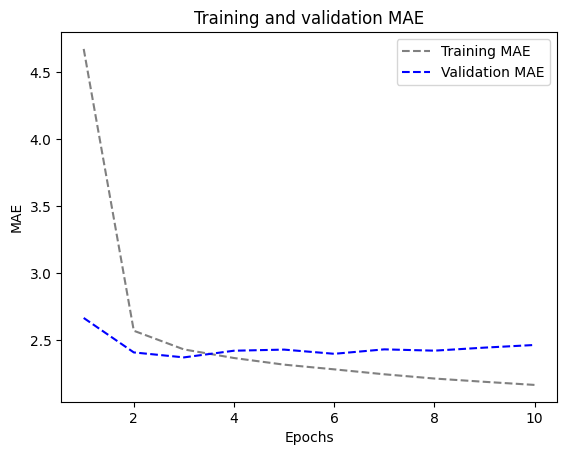

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
mad = layers.Dropout(0.5)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 62s 72ms/step - loss: 47.7730 - mae: 5.1526 - val_loss: 13.5424 - val_mae: 2.7778
Epoch 2/10
819/819 [==============================] - 60s 74ms/step - loss: 20.2169 - mae: 3.4533 - val_loss: 10.0303 - val_mae: 2.4637
Epoch 3/10
819/819 [==============================] - 61s 75ms/step - loss: 18.3837 - mae: 3.2974 - val_loss: 9.5094 - val_mae: 2.4083
Epoch 4/10
819/819 [==============================] - 72s 88ms/step - loss: 17.5288 - mae: 3.2206 - val_loss: 9.4934 - val_mae: 2.4092
Epoch 5/10
819/819 [==============================] - 78s 95ms/step - loss: 16.8829 - mae: 3.1622 - val_loss: 9.4932 - val_mae: 2.4038
Epoch 6/10
819/819 [==============================] - 74s 90ms/step - loss: 16.2937 - mae: 3.1057 - val_loss: 9.4807 - val_mae: 2.4031
Epoch 7/10
819/819 [==============================] - 74s 90ms/step - loss: 15.9448 - mae: 3.0736 - val_loss: 9.2669 - val_mae: 2.3805
Epoch 8/10
819/819 [==============================] -

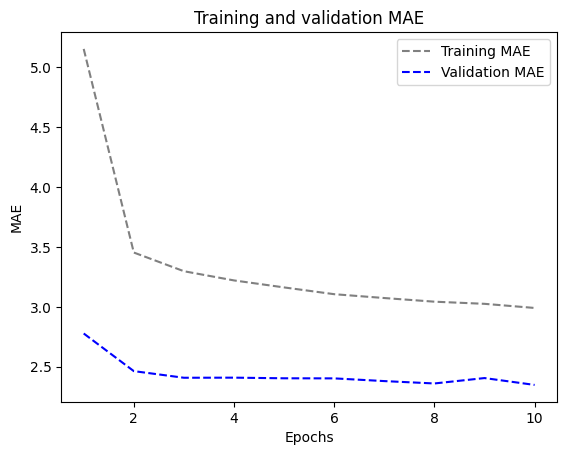

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(16, return_sequences=True)(inputs)
mad = layers.LSTM(16)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 98s 114ms/step - loss: 38.9422 - mae: 4.5314 - val_loss: 13.2483 - val_mae: 2.7637
Epoch 2/10
819/819 [==============================] - 94s 114ms/step - loss: 10.4086 - mae: 2.4994 - val_loss: 10.4168 - val_mae: 2.5084
Epoch 3/10
819/819 [==============================] - 94s 114ms/step - loss: 8.9515 - mae: 2.3309 - val_loss: 10.3111 - val_mae: 2.5060
Epoch 4/10
819/819 [==============================] - 93s 114ms/step - loss: 8.3041 - mae: 2.2460 - val_loss: 9.9955 - val_mae: 2.4730
Epoch 5/10
819/819 [==============================] - 93s 113ms/step - loss: 7.8176 - mae: 2.1817 - val_loss: 10.7497 - val_mae: 2.5589
Epoch 6/10
819/819 [==============================] - 93s 114ms/step - loss: 7.4091 - mae: 2.1241 - val_loss: 10.8167 - val_mae: 2.5792
Epoch 7/10
819/819 [==============================] - 94s 115ms/step - loss: 7.1159 - mae: 2.0805 - val_loss: 11.1633 - val_mae: 2.6084
Epoch 8/10
819/819 [===========================

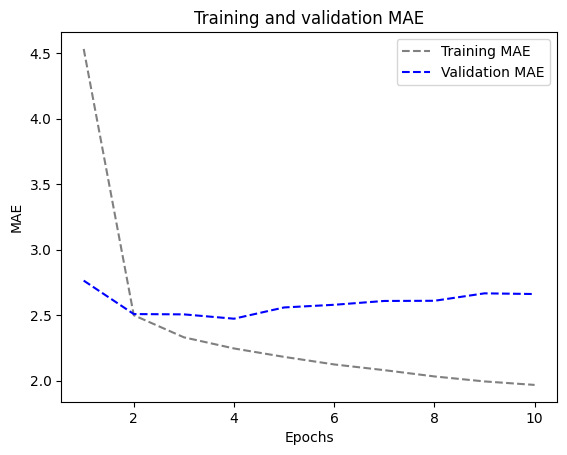

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(32, return_sequences=True)(inputs)
mad = layers.LSTM(32)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 134s 160ms/step - loss: 20.0122 - mae: 3.2151 - val_loss: 10.2538 - val_mae: 2.4998
Epoch 2/10
819/819 [==============================] - 129s 158ms/step - loss: 7.9205 - mae: 2.1906 - val_loss: 10.8438 - val_mae: 2.5947
Epoch 3/10
819/819 [==============================] - 127s 155ms/step - loss: 6.3414 - mae: 1.9527 - val_loss: 11.1191 - val_mae: 2.6397
Epoch 4/10
819/819 [==============================] - 127s 156ms/step - loss: 5.3856 - mae: 1.7918 - val_loss: 12.6556 - val_mae: 2.8199
Epoch 5/10
819/819 [==============================] - 128s 157ms/step - loss: 4.7296 - mae: 1.6747 - val_loss: 12.5435 - val_mae: 2.7816
Epoch 6/10
819/819 [==============================] - 129s 158ms/step - loss: 4.1745 - mae: 1.5706 - val_loss: 13.7602 - val_mae: 2.9211
Epoch 7/10
819/819 [==============================] - 131s 160ms/step - loss: 3.7303 - mae: 1.4835 - val_loss: 13.0765 - val_mae: 2.8446
Epoch 8/10
819/819 [====================

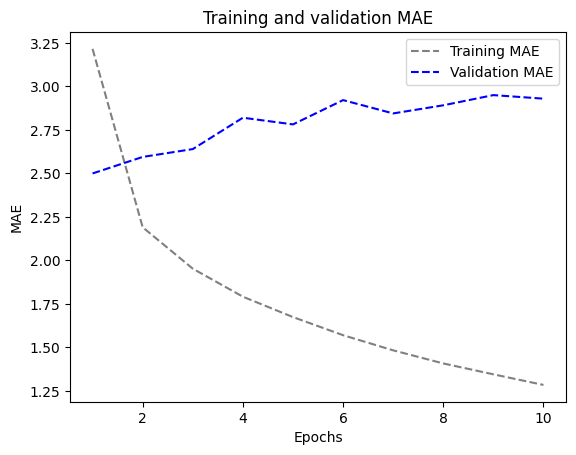

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(8, return_sequences=True)(inputs)
mad = layers.LSTM(8)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 76s 88ms/step - loss: 68.5513 - mae: 6.3289 - val_loss: 35.2620 - val_mae: 4.4571
Epoch 2/10
819/819 [==============================] - 71s 86ms/step - loss: 21.3442 - mae: 3.4364 - val_loss: 13.1404 - val_mae: 2.7326
Epoch 3/10
819/819 [==============================] - 71s 86ms/step - loss: 11.6830 - mae: 2.6500 - val_loss: 9.9465 - val_mae: 2.4488
Epoch 4/10
819/819 [==============================] - 71s 86ms/step - loss: 10.2741 - mae: 2.4996 - val_loss: 9.4200 - val_mae: 2.3832
Epoch 5/10
819/819 [==============================] - 70s 86ms/step - loss: 9.8020 - mae: 2.4412 - val_loss: 9.6406 - val_mae: 2.4136
Epoch 6/10
819/819 [==============================] - 69s 84ms/step - loss: 9.4886 - mae: 2.4054 - val_loss: 9.2494 - val_mae: 2.3653
Epoch 7/10
819/819 [==============================] - 69s 84ms/step - loss: 9.2551 - mae: 2.3746 - val_loss: 9.0740 - val_mae: 2.3423
Epoch 8/10
819/819 [==============================] - 69

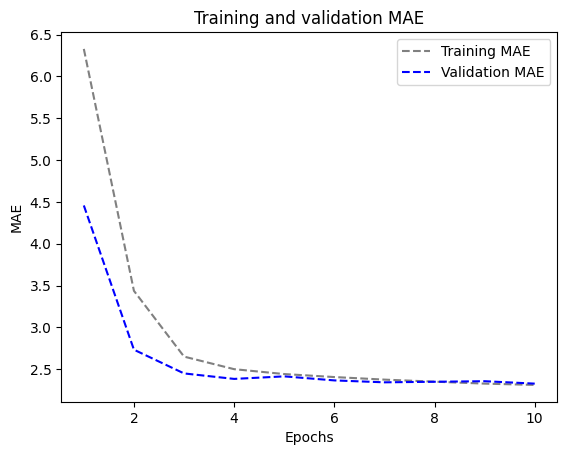

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **6.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
mad = layers.LSTM(8, recurrent_dropout=0.5)(mad)
mad = layers.Dropout(0.5)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 108s 127ms/step - loss: 77.0114 - mae: 6.7599 - val_loss: 37.1354 - val_mae: 4.5161
Epoch 2/10
819/819 [==============================] - 103s 126ms/step - loss: 32.5645 - mae: 4.2594 - val_loss: 14.3394 - val_mae: 2.8245
Epoch 3/10
819/819 [==============================] - 104s 127ms/step - loss: 24.3290 - mae: 3.7287 - val_loss: 11.1261 - val_mae: 2.5550
Epoch 4/10
819/819 [==============================] - 104s 126ms/step - loss: 22.4013 - mae: 3.5906 - val_loss: 10.3928 - val_mae: 2.4880
Epoch 5/10
819/819 [==============================] - 104s 127ms/step - loss: 21.1114 - mae: 3.4941 - val_loss: 9.9215 - val_mae: 2.4304
Epoch 6/10
819/819 [==============================] - 105s 128ms/step - loss: 20.0652 - mae: 3.4086 - val_loss: 9.8693 - val_mae: 2.4438
Epoch 7/10
819/819 [==============================] - 104s 127ms/step - loss: 19.2277 - mae: 3.3410 - val_loss: 10.3424 - val_mae: 2.4983
Epoch 8/10
819/819 [================

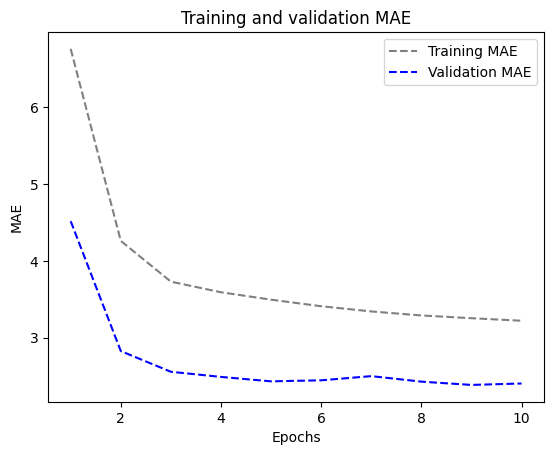

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 59s 67ms/step - loss: 27.2882 - mae: 3.7523 - val_loss: 10.5336 - val_mae: 2.5275
Epoch 2/10
819/819 [==============================] - 53s 65ms/step - loss: 9.4547 - mae: 2.4061 - val_loss: 9.9216 - val_mae: 2.4307
Epoch 3/10
819/819 [==============================] - 53s 65ms/step - loss: 8.3159 - mae: 2.2572 - val_loss: 10.0046 - val_mae: 2.4350
Epoch 4/10
819/819 [==============================] - 54s 65ms/step - loss: 7.7937 - mae: 2.1843 - val_loss: 10.3709 - val_mae: 2.4700
Epoch 5/10
819/819 [==============================] - 53s 65ms/step - loss: 7.4481 - mae: 2.1364 - val_loss: 10.7326 - val_mae: 2.5190
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 7.1915 - mae: 2.0988 - val_loss: 10.8682 - val_mae: 2.5439
Epoch 7/10
819/819 [==============================] - 57s 70ms/step - loss: 6.8651 - mae: 2.0517 - val_loss: 11.2590 - val_mae: 2.5855
Epoch 8/10
819/819 [==============================] - 5

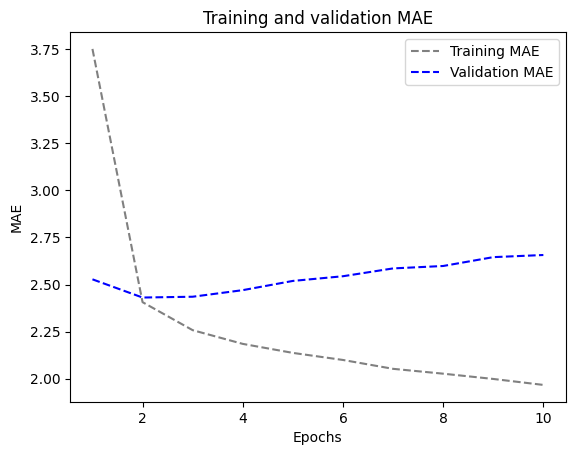

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
mad = layers.Conv1D(64, 3, activation='relu')(inputs)
mad = layers.MaxPooling1D(3)(mad)
mad = layers.Conv1D(128, 3, activation='relu')(mad)
mad = layers.GlobalMaxPooling1D()(mad)
mad = layers.Reshape((-1, 128))(mad)  # Reshape the data to be 3D
mad = layers.LSTM(16)(mad)
outputs = layers.Dense(1)(mad)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 21ms/step - loss: 50.8257 - mae: 5.3301 - val_loss: 25.9684 - val_mae: 3.9419
Epoch 2/10
819/819 [==============================] - 16s 20ms/step - loss: 17.6037 - mae: 3.2296 - val_loss: 21.9298 - val_mae: 3.7451
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.3486 - mae: 2.9332 - val_loss: 21.9679 - val_mae: 3.7051
Epoch 4/10
819/819 [==============================] - 15s 19ms/step - loss: 12.6865 - mae: 2.7523 - val_loss: 23.8628 - val_mae: 3.9412
Epoch 5/10
819/819 [==============================] - 14s 18ms/step - loss: 11.5201 - mae: 2.6182 - val_loss: 23.1264 - val_mae: 3.8054
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 10.6992 - mae: 2.5180 - val_loss: 23.6485 - val_mae: 3.9116
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 9.9950 - mae: 2.4267 - val_loss: 22.9874 - val_mae: 3.8469
Epoch 8/10
819/819 [=============================

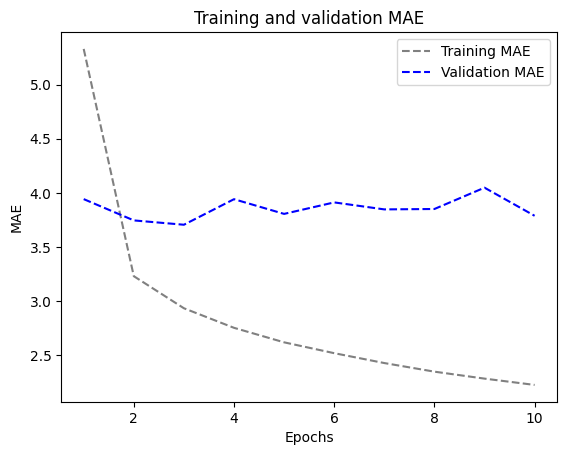

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built **14** models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** Stacked setup with 16 units

**Model 10:** Stacked setup with 32 units

**Model 11:** Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

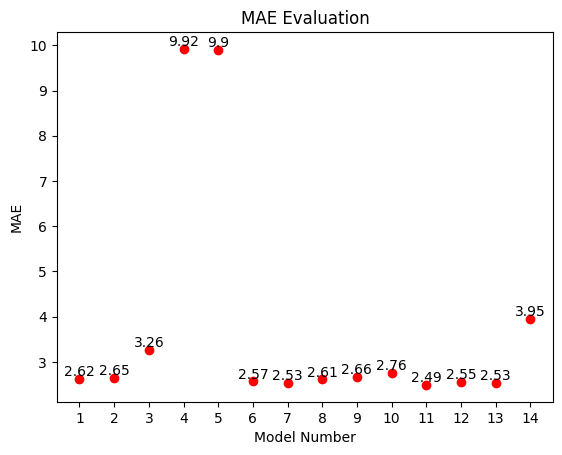

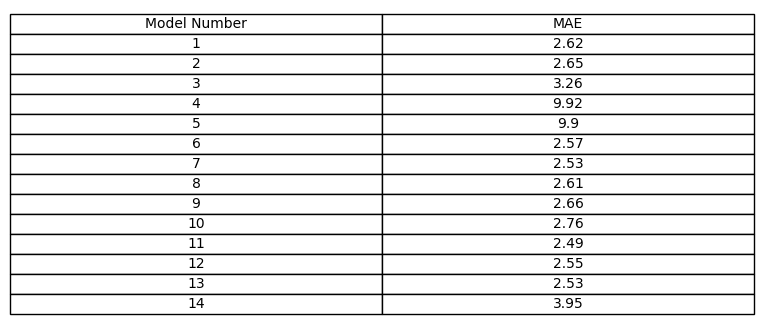

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.65,3.26,9.92,9.90,2.57,2.53,2.61,2.66,2.76,2.49,2.55,2.53,3.95)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

# Creating a table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table_data = list(zip(Models, Mae))
table = ax.table(cellText=table_data, colLabels=['Model Number', 'MAE'], cellLoc = 'center', loc='center')

# Adding style to the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

